In [1]:
## load in functions for workshop
source("schmidtWorkshop.R")

# TreeWAS Analysis in UK Biobank data sets

Framework to test for association between genetic variation and any given UK Biobank clinical phenotype. Features include:
1. Accomodates tests for association with different types of genetic variation, such as SNPs and polygenic risk scores.
2. Jointly analyses and quantifies evidence for association at each clinical phenotype and estimates the genetic coefficients of effects.
3. Performs conditional analysis to control for confounder effects (e.g., age and sex) or to find independent association signals within a locus.
4. Models the correlation structure of genetic effects across observed clinical phenotypes using a priori knowledge of phenotype relationships obtained from a diagnosis classification tree, such as the ICD-10.

# MI GRS TreeWAS in the UK Biobank HES data set
Load precomputed likelihood surfaces for each node in the classification tree

In [2]:
MI_GRS.data = MI_GRS.lk.surfs()
MI_GRS.lk.surfs = MI_GRS.data$llk.data
MI_GRS.tree = MI_GRS.data$tree
MI_GRS.prior = MI_GRS.data$prior

Plot the likelihood surfaces at a terminal node

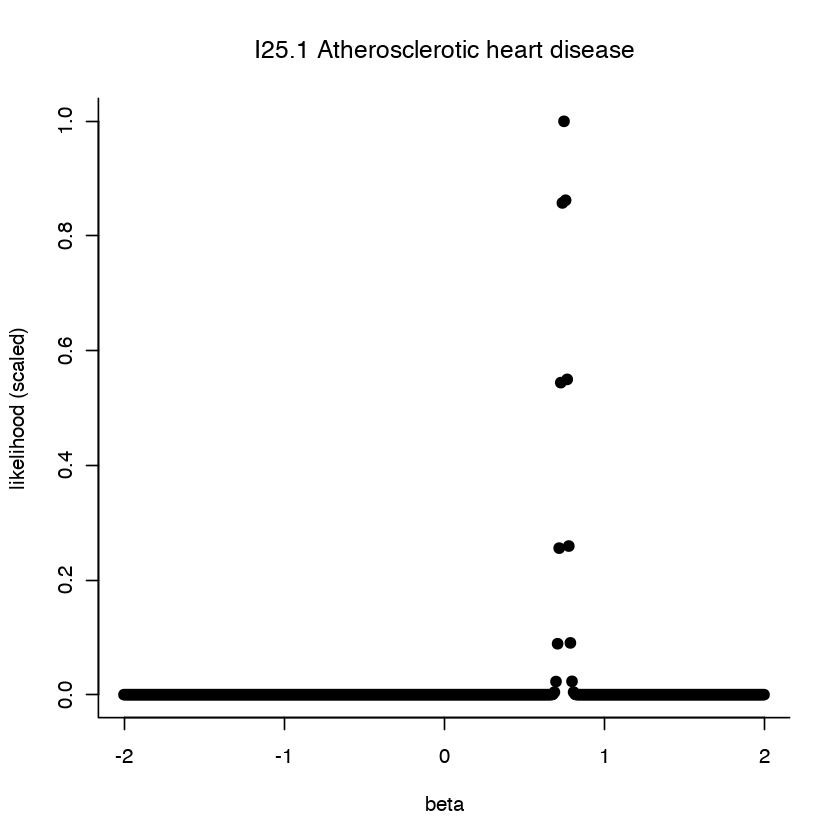

In [6]:
code <- 'I251'  # or try code G35
grs.plot.lk.surface(
    code,
    tree     = MI_GRS.tree,
    prior    = MI_GRS.prior,
    lk.surfs = MI_GRS.lk.surfs
)

The prior $\theta$ determines the expected correlation between genetic coefficients across phenotypes. The coefficients at a parent node can be inherited by a child node with probability $e^{-\theta}$ or can transition to a new uncorrelated value, with probability $1-e^{\theta}$.

The prior $\pi_1$ determines the expected number of nodes in the tree with non-zero coefficients.

In [7]:
## Define prior values
theta <- 1/3
pi1 <- 1/1000
## Transition probabilities
p.stay <- exp(-theta);
p.switch <- 1-p.stay;

Calculate the evidence, $\text{BF}_{\text{tree}}$, that the MI GRS is associated with at least one diagnosis term in the ICD-10 classification tree.

In [3]:
lBF = grs.calc.lBF(
    tree     = MI_GRS.tree,
    prior    = MI_GRS.prior, 
    p.stay   = p.stay, 
    p.switch = p.switch, 
    llk.data = MI_GRS.lk.surfs
)
paste0("The Tree BF is ", round(lBF,2),'.')

ERROR: Error in grs.calc.lBF(tree = MI_GRS.tree, prior = MI_GRS.prior, p.stay = p.stay, : object 'p.stay' not found


Calculate marginal posterior on risk profile across the diagnosis terms in the ICD-10.

In [ ]:
pp = grs.marginal.posterior(
    tree     = MI_GRS.tree, 
    prior    = MI_GRS.prior, 
    p.stay   = p.stay, 
    p.switch = p.switch,
    llk.data = MI_GRS.lk.surfs
)

Calculate number of active nodes (non-zero genetic coefficients) in the tree

In [8]:
pp.thr = 0.75
paste0("There are ",sum(pp$POST_ACTIVE >= pp.thr), " active nodes.")

[1] "There are 355 active nodes."

Plot the ICD-10 classification tree with the TreeWAS results. Trim the tree such that only nodes with $PP$ above a defined threshold are shown.

In [ ]:
plot <- grs.draw_tree(
    tree         = MI_GRS.tree,
    pp           = pp,
    tree_title   = "MI GRS",
    trim_tree_pp = 0.25
)
plot

Look at the ICD-10 codes identified by TreeWAS analysis but not in the univariate analysis.

In [10]:
t = as.data.table( pp)
uni = mi.univariate()[ pValue < 8e-6, .( coding = Code, Univariate = TRUE )]
t = uni[t, on = "coding"]
t[, Univariate := ifelse( is.na( Univariate ), FALSE, TRUE)]
#t[ POST_ACTIVE > 0.999, .( coding, meaning, COUNTS, post = 1 - POST_ACTIVE, Univariate)][ order( post)]
t[ POST_ACTIVE > 0.99 & !is.na( COUNTS ) & Univariate == FALSE, .( coding, meaning, COUNTS, post = 1 - POST_ACTIVE, Univariate)][ order( post)]


coding,meaning,COUNTS,post,Univariate
I73,I73 Other peripheral vascular diseases,1,6.372607e-06,FALSE
I702,I70.2 Atherosclerosis of arteries of the extremities,555,1.537223e-04,FALSE
I220,I22.0 Subsequent myocardial infarction of anterior wall,92,1.713416e-04,FALSE
I228,I22.8 Subsequent myocardial infarction of other sites,78,2.316062e-04,FALSE
Z959,"Z95.9 Presence of cardiac and vascular implant and graft, unspecified",224,3.849170e-04,FALSE
I490,I49.0 Ventricular fibrillation and flutter,333,4.912591e-04,FALSE
I460,I46.0 Cardiac arrest with successful resuscitation,586,5.373121e-04,FALSE
I639,"I63.9 Cerebral infarction, unspecified",2442,5.426719e-04,FALSE
I517,I51.7 Cardiomegaly,2565,7.276683e-04,FALSE
I64,"I64 Stroke, not specified as haemorrhage or infarction",1073,9.561926e-04,FALSE


Summarise comparison of findings in both analyses.

In [11]:
t[ POST_ACTIVE > 0.99 & !is.na( COUNTS ), .N, by = "Univariate" ]

Univariate,N
FALSE,19
TRUE,48
